In [1]:
from collections import defaultdict
import itertools
import mthree
import numpy as np
import os
import matplotlib.pyplot as plt
from qiskit import Aer, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.circuit.library import FermionicGaussianState
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from mzm_generation import (
    bdg_hamiltonian,
    compute_edge_correlation,
    compute_edge_correlation_measurement_corrected,
    compute_energy,
    compute_energy_measurement_corrected,
    compute_parity,
    compute_parity_measurement_corrected,
    edge_correlation_op,
    expectation,
    KitaevHamiltonianTask,
    kitaev_hamiltonian,
    load,
    MeasurementErrorCalibrationTask)

In [2]:
# boilerplate
converter = QubitConverter(mapper=JordanWignerMapper())
simulator_backend = Aer.get_backend("statevector_simulator")

In [3]:
# set parameters

# number of modes
n_modes = 3

# x values
num = 20
x_min = 1e-8
x_max = 3.1
x_values = np.linspace(x_min, x_max, num=num)

# number of shots
shots = 10000

# number of shots for measurement error calibration
measurement_error_calibration_shots = 50000

# qubits
qubits = [0, 1, 2]

# experiment id used for saving data
experiment_id = '2022-01-11T16:50:30.417884_ibmq_manila'

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

In [4]:
# analyze results for Hamiltonian expectation
def powerset(items):
    return itertools.chain.from_iterable(
        itertools.combinations(items, k)
        for k in range(len(items) + 1))

exact_series = defaultdict(list)
experiment_series = defaultdict(list)
measurement_corrected_series = defaultdict(list)

for chemical_potential in x_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    hamiltonian_dense = hamiltonian_jw.to_matrix()
    # compute eigenvalues
    transformation_matrix, orbital_energies, constant = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    energy_shift = -0.5 * np.sum(orbital_energies) - constant
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        # load data
        task = KitaevHamiltonianTask(
            experiment_id=experiment_id,
            n_modes=n_modes,
            tunneling=-1.0,
            superconducting=1.0,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals,
            shots=shots)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
                  for pauli_string, quasi_dist in data['quasis'].items()}
        # exact energy
        circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
        transpiled_circuit = circuit.decompose()
        state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
        exact_energy = np.real(expectation(hamiltonian_dense, state))
        exact_series[occupied_orbitals].append(exact_energy + energy_shift) 
        # experimental energy
        experiment_energy = compute_energy(measurements, hamiltonian_jw)
        experiment_series[occupied_orbitals].append(experiment_energy + energy_shift)
        # experimental energy with measurement error mitigation
        measurement_corrected_energy = compute_energy_measurement_corrected(
            quasis, hamiltonian_jw)
        measurement_corrected_series[occupied_orbitals].append(measurement_corrected_energy + energy_shift)

/home/kjs/projects/qiskit-nature/qiskit_nature/operators/second_quantization/quadratic_hamiltonian.py:103: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(terms, register_length=self._n_orbitals)


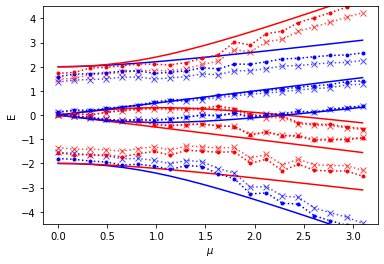

In [5]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in exact_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, color=color)
for occupied_orbitals, series in experiment_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, 'x:', color=color, alpha=0.7)
for occupied_orbitals, series in measurement_corrected_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, '.:', color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-4.5, 4.5)
#plt.legend()
plt.savefig(f'plots/{experiment_id}/energy.png', dpi=300)
plt.show()

In [6]:
# analyze results for edge correlation
edge_correlation = edge_correlation_op(n_modes)
edge_correlation_jw = converter.convert(edge_correlation)
edge_correlation_dense = edge_correlation_jw.to_matrix()

edge_corr_exact_series = defaultdict(list)
edge_corr_experiment_series = defaultdict(list)
edge_corr_measurement_corrected_series = defaultdict(list)

for chemical_potential in x_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        task = KitaevHamiltonianTask(
            experiment_id=experiment_id,
            n_modes=n_modes,
            tunneling=-1.0,
            superconducting=1.0,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals,
            shots=shots)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
          for pauli_string, quasi_dist in data['quasis'].items()}
        # exact correlation
        circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
        transpiled_circuit = circuit.decompose()
        state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
        exact_correlation = np.real(expectation(edge_correlation_dense, state))
        edge_corr_exact_series[occupied_orbitals].append(exact_correlation)
        # experimental correlation
        experiment_correlation = compute_edge_correlation(measurements)
        edge_corr_experiment_series[occupied_orbitals].append(experiment_correlation)
        # experimental correlation with measurement error mitigation
        measurement_corrected_correlation = compute_edge_correlation_measurement_corrected(quasis)
        edge_corr_measurement_corrected_series[occupied_orbitals].append(measurement_corrected_correlation)

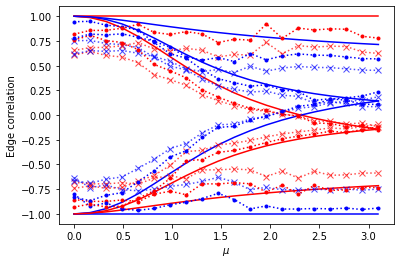

In [7]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in edge_corr_exact_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, color=color)
for occupied_orbitals, series in edge_corr_experiment_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, 'x:', color=color, alpha=0.7)
for occupied_orbitals, series in edge_corr_measurement_corrected_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, '.:', color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Edge correlation')
ax.set_ylim(-1.1, 1.1)
#plt.legend()
plt.savefig(f'plots/{experiment_id}/edge_correlation.png', dpi=300)
plt.show()

In [8]:
# analyze results for parity
parity_exact_series = defaultdict(list)
parity_experiment_series = defaultdict(list)
parity_measurement_corrected_series = defaultdict(list)

for chemical_potential in x_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    W1 = transformation_matrix[:, :n_modes]
    W2 = transformation_matrix[:, n_modes:]
    full_transformation = np.block([[W1, W2], [W2.conj(), W1.conj()]])
    hamiltonian_parity = np.real(np.sign(np.linalg.det(full_transformation)))
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        task = KitaevHamiltonianTask(
            experiment_id=experiment_id,
            n_modes=n_modes,
            tunneling=-1.0,
            superconducting=1.0,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals,
            shots=shots)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
                  for pauli_string, quasi_dist in data['quasis'].items()}
        # exact parity
        exact_parity = (-1) ** len(occupied_orbitals) * hamiltonian_parity
        parity_exact_series[occupied_orbitals].append(exact_parity)
        # experimental parity
        experiment_parity = compute_parity(measurements)
        parity_experiment_series[occupied_orbitals].append(experiment_parity)
        # experimental parity with measurement error mitigation
        measurement_corrected_parity = compute_parity_measurement_corrected(quasis)
        parity_measurement_corrected_series[occupied_orbitals].append(measurement_corrected_parity)

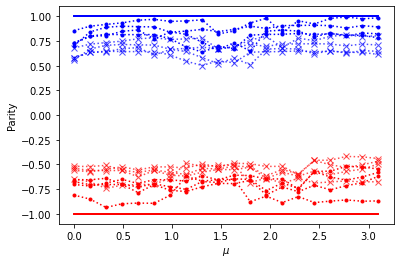

In [9]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in parity_exact_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, color=color)
for occupied_orbitals, series in parity_experiment_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, 'x:', color=color, alpha=0.7)
for occupied_orbitals, series in parity_measurement_corrected_series.items():
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(x_values, series, '.:', color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Parity')
ax.set_ylim(-1.1, 1.1)
#plt.legend()
plt.savefig(f'plots/{experiment_id}/parity.png', dpi=300)
plt.show()

In [10]:
# compute BdG Hamiltonian eigenvalues
bdg_series = np.zeros((num, 2 * n_modes))

for i, chemical_potential in enumerate(x_values):
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=-1.0,
        superconducting=1.0,
        chemical_potential=chemical_potential)
    hamiltonian_bdg = bdg_hamiltonian(hamiltonian_quad)
    eigs, _ = np.linalg.eigh(hamiltonian_bdg)
    bdg_series[i] = eigs

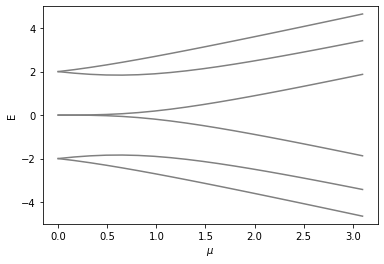

In [11]:
# plot
fig, ax = plt.subplots()

for i in range(2 * n_modes):
    ax.plot(x_values, bdg_series[:, i], color='gray')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()